In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler         # for scaling between 0 to 1
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)

print(pd.__version__)
print(np.__version__)
print(sns.__version__)

2.2.3
1.26.4
0.13.2


In [68]:
#Loading data and getting statistics 
Data_frame=pd.read_csv("tested.csv")
print(Data_frame.head())
print(Data_frame.tail())
print("Information about the dataset .........")
print(Data_frame.info())
print(Data_frame.describe())
print("checking for the missing values .........")
print(Data_frame.isnull().sum())

   PassengerId  Survived  Pclass  \
0          892         0       3   
1          893         1       3   
2          894         0       2   
3          895         0       3   
4          896         1       3   

                                           Name     Sex   Age  SibSp  Parch  \
0                              Kelly, Mr. James    male  34.5      0      0   
1              Wilkes, Mrs. James (Ellen Needs)  female  47.0      1      0   
2                     Myles, Mr. Thomas Francis    male  62.0      0      0   
3                              Wirz, Mr. Albert    male  27.0      0      0   
4  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0      1      1   

    Ticket     Fare Cabin Embarked  
0   330911   7.8292   NaN        Q  
1   363272   7.0000   NaN        S  
2   240276   9.6875   NaN        Q  
3   315154   8.6625   NaN        S  
4  3101298  12.2875   NaN        S  
     PassengerId  Survived  Pclass                          Name     Sex  \
413       

In [69]:
# Data cleaning and feature_engineering the data
def preprocessing_data(df:pd.DataFrame):
    df.drop(columns=["PassengerId","Name","Ticket","Cabin"],inplace=True)
    df.drop(columns=["Embarked"],inplace=True)
    
    fill_missing_ages_fares(df)
    # similar to one - hot encoding sparse
    gender={
        "male":1,
        "female":0
    }
    df["Sex"]=df["Sex"].map(gender)
    df["FamilySize"]=df["SibSp"]+df["Parch"]
    df["IsAlone"]=np.where(df["FamilySize"]==0 , 1 ,0)
    df["FareBin"]=pd.qcut(df["Fare"],4,labels=False)
    df["AgeBin"]=pd.cut(df["Age"],bins=[0,15,30,45,80],labels=False)
    return df

def fill_missing_ages_fares(df:pd.DataFrame):
    age_fill_map={}
    for pclass in df["Pclass"].unique():
        if pclass not in age_fill_map:
            age_fill_map[pclass]=df[df["Pclass"] == pclass]["Age"].mean()
    df["Age"]=df.apply(lambda row:age_fill_map[row["Pclass"]] if pd.isnull(row["Age"]) else row["Age"],axis=1)
    fare_fill={}
    for pclass in df["Pclass"].unique():
        if pclass not in fare_fill:
            fare_fill[pclass]=df[df["Pclass"] == pclass]["Fare"].mean()
    df["Age"]=df.apply(lambda row:age_fill_map[row["Pclass"]] if pd.isnull(row["Age"]) else row["Age"],axis=1)
    df["Fare"]=df.apply(lambda row:fare_fill[row["Pclass"]] if pd.isnull(row["Fare"]) else row["Fare"],axis=1)

In [70]:
dataframe_new=preprocessing_data(Data_frame)
# train and test split and data ready
X=dataframe_new.drop(columns=["Survived"])
y=dataframe_new["Survived"]

x_train,x_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=42)
scaler=MinMaxScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)
print(dataframe_new.isnull().sum())
print(dataframe_new.columns)

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
FamilySize    0
IsAlone       0
FareBin       0
AgeBin        0
dtype: int64
Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'FamilySize', 'IsAlone', 'FareBin', 'AgeBin'],
      dtype='object')


In [71]:
#Hyper parameter tuning
def tune_model(X_train,y_train):
    param_grid={
        "n_neighbors":range(1,30),
        "metric":["euclidean","manhattan","minkowski"],
        "weights":["uniform","distance"]
    }
    model=KNeighborsClassifier()
    grid_search=GridSearchCV(model,param_grid,cv=5,n_jobs=-1)
    grid_search.fit(X_train,y_train)
    return grid_search.best_estimator_

best_model=tune_model(x_train,y_train)


In [72]:
#predictions
def evaluate_model(model,x_test,y_test):
    prediction=model.predict(x_test)
    accuracy=accuracy_score(y_test,prediction)
    matrix=confusion_matrix(y_test,prediction)
    class_report=classification_report(y_test,prediction)
    return accuracy,matrix,class_report
accuracy,matrix,report=evaluate_model(best_model,x_test,y_test)
print(f"Accuracy Score:{accuracy*100:.2f}%")
print(matrix)
print(report)

Accuracy Score:100.00%
[[50  0]
 [ 0 34]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



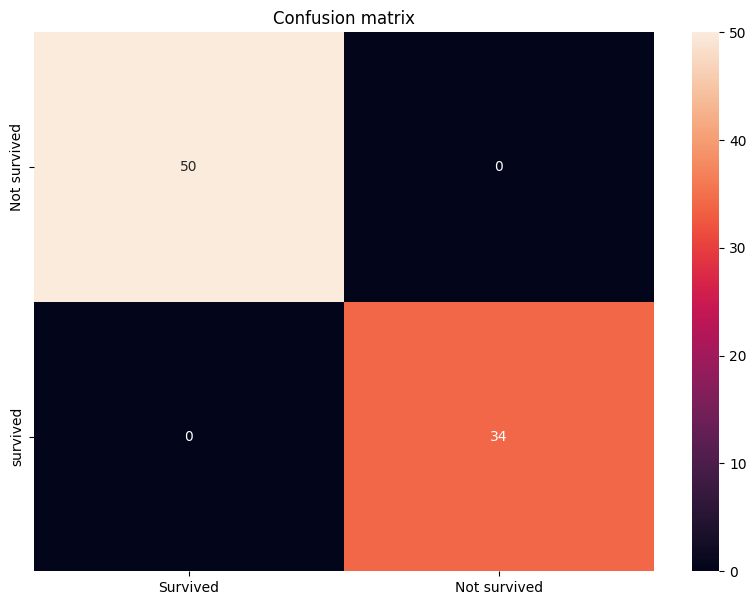

In [73]:
def plot_model(matrix):
    plt.figure(figsize=(10,7))
    sns.heatmap(matrix,annot=True,xticklabels=["Survived","Not survived"],yticklabels=["Not survived","survived"])
    plt.title("Confusion matrix")
    plt.show()



plot_model(matrix)
        